# Yolov5 (large) Pytorch
This notebook shows how to compile Yolov5/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK.

### Install dependencies

In [ ]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies

### Now load a pre-trained model from model zoo and compile it

In [ ]:
import torch
import torch_neuron
from torchvision import models

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5l', pretrained=True)
model.eval()

x = torch.rand([1, 3, 640, 640], dtype=torch.float32)
y = model(x)

traced_model = torch.jit.trace(model, x) # check if it is traceable

### Analyze it to see if it is compatible with NeuronSDK

In [ ]:
torch.neuron.analyze_model(model, example_inputs=x)

### Finally compile it

In [ ]:
model_neuron = torch.neuron.trace(
    model, 
    example_inputs=x,
    skip_compiler=False, 
    dynamic_batch_size=False,
    verbose='debug',
    compiler_workdir="logs/"
)

## Export to saved model
model_neuron.save("yolov5l_neuron.pt")

## A quick benchmark

In [ ]:
y = model_neuron(x)
%timeit model_neuron(x)

## Here we have the post-processing code
This code computes the bounding boxes+classes+confidence of each object. These functions need to be kept outside the model to keep the compatibility with NeuronSDK.

In [ ]:
class_names = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

input tensor shape: torch.Size([1, 3, 640, 640])


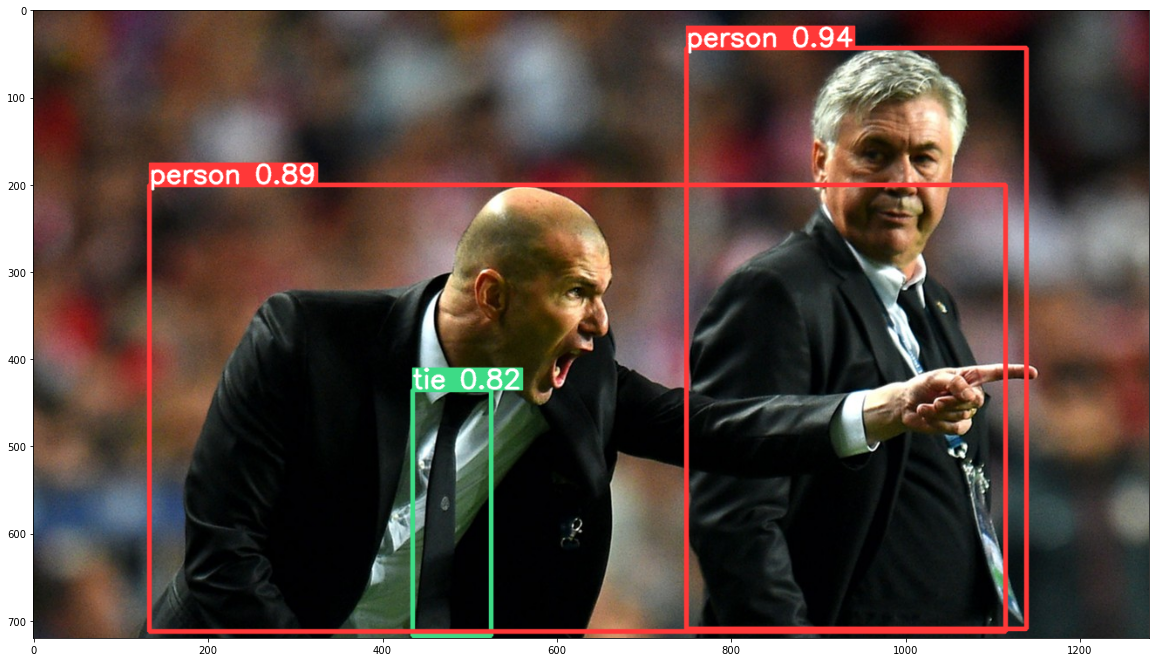

In [4]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# imports from Yolov5 --> You need to install the requirements.txt to have them (1st cell)
from utils.general import non_max_suppression, scale_coords
from utils.augmentations import letterbox
from utils.plots import Annotator, colors

# Download the test image
if not os.path.exists("zidane.jpg"):
    !wget https://ultralytics.com/images/zidane.jpg

img = cv2.imread("zidane.jpg")

# preprocessing based on AutoShape's forward() call https://github.com/ultralytics/yolov5/blob/master/models/common.py#L560
x = letterbox(img[...,::-1], new_shape=(640,640), auto=False)[0] # letterbox to the customer's desired image size
x = np.expand_dims(x, 0)
x = np.ascontiguousarray(x.transpose((0, 3, 1, 2)))  # BHWC to BCHW
x = torch.from_numpy(x) / 255
print(f"input tensor shape: {x.shape}")

y = model_neuron(x) # do inference with Neuron model

det = non_max_suppression(y)[0]

annotator = Annotator(img, line_width=3, example=str(class_names))
det[:, :4] = scale_coords(x.shape[2:], det[:, :4], img.shape).round()
# Write results
for *xyxy, conf, cls in reversed(det):
    c = int(cls)  # integer class
    label = f'{class_names[c]} {conf:.2f}'
    annotator.box_label(xyxy, label, color=colors(c, True))

plt.figure(figsize=(20,20))
plt.imshow(img[...,::-1])  # BGR to RGB
plt.show()